# UCI DH MTB Race Analysis
## Setup
#### Import Libraries

If you do not have these libraries available, you should install them using `pip`

In [21]:
import pandas as pd
import numpy as np
from decimal import Decimal, ROUND_HALF_UP
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
from colour import Color
from cycler import cycler

#### Config

Widen display area to prevent column wrapping, and always show all columns for debug

In [24]:
pd.set_option('display.width', 2000)
pd.set_option('display.max_columns', None)

## Config

Analysis choices

Race:
1. Losinj
1. Fort William
1. Leogang
1. Val di Sole
1. Vallnord
1. Mont-Sainte-Anne
1. La Bresse

Gender:
- m: Men
- f: Women

Other:
- `topX`: How many racers are we interested in comparing?
- `splits`: How many timing splits are there in the race?

In [260]:
race = 1
gender = 'm'
topX = 20
splits = 5 # Could detect this from dataset? @todo

In [242]:
# KISS!
# class conf():
#     topX = 20
#     splits = 5
# config = conf



List of season races to build the filename 

In [243]:
races = [
    'losinj',
    'fortbill',
    'leogang',
    'valdisole',
    'vallnord',
    'msa',
    'labresse',
]
raceName = races[race-1]

#### Import Data

Read the CSV file, then clear out the DNF/DNS entries

In [244]:
file = str(race) + '_' + raceName + '_' + gender + '.results.csv'
df = pd.read_csv( file, index_col=0 )
df = df.dropna() # remove DNF/DNS

Do some input checks and error corrects

In [245]:
if topX > len(df):
    topX = len(df)

Peek at the data if we wish to make sure it looks correct 

In [246]:
print( df.head() )
print( df.tail() )

   bib    id               name  rank  speed  split1  split2  split3   split4   split5    status          uci
0    1  1001         GWIN Aaron     1  47.21  20.810  52.860  80.785  116.514  139.193  Finished  10006516663
1   13  1013          SHAW Luca     2  49.60  20.613  54.162  82.787  118.094  139.991  Finished  10008813442
2   16  1016         LUCAS Dean     3  48.00  20.680  53.964  81.870  117.830  140.328  Finished  10008103322
3   19  1019  BLENKINSOP Samuel     4  49.55  21.224  54.699  82.891  118.749  141.107  Finished  10004485929
4   34  1034     NORTON Dakotah     5  47.50  20.904  54.898  83.172  119.061  141.821  Finished  10010038167
    bib    id                 name  rank  speed  split1  split2   split3   split4   split5    status          uci
57   70  1070    COLOMBO Francesco    58  46.59  21.563  56.967  100.135  139.423  163.414  Finished  10008073010
58   72  1072           WEBER Lutz    59  46.37  21.527  58.627   91.607  140.329  168.483  Finished  1000681695

Function that converts a time in seconds in to a timedelta, used later on

In [183]:
def convertToDelta( timestring ):
    timestring = str(timestring)

    if ":" not in timestring:
        timestring = str(Decimal( timestring ).quantize( Decimal('.001' ), rounding=ROUND_HALF_UP ))
        timestring = "0:" + timestring

    timestring = "0:" + timestring

    return pd.to_timedelta( timestring )

Function to format a timedelta for display `hh:mm:ss.xxx` (drop the days)

In [147]:
def formatDelta( time ):
    return ':'.join(str(time).split(':')[1:3])[:-3]

#### Expand Dataset

Calculate and add all the extra columns we need for split and sector differences and their rankings

In [247]:
for i in range( 1, splits+1 ):
    split = 'split' + str(i)
    sector = split + '_sector'
    df[split + '_rank'] = df[split].rank(method='dense')
    df[split + '_vs_best'] = (df[split] - df[split].min())
    df[split + '_vs_winner'] = (df[split] - df[split][0])
    
    if i > 1:
        df[split + '_sector'] = df[split] - df['split' + str(i-1)]
        df[split + '_sector_rank'] = df[sector].rank(method='dense')
        df[split + '_sector_vs_best'] = (df[sector] - df[sector].min())
        df[split + '_sector_vs_winner'] = (df[sector] - df[sector][0])

Again, can take a peek here to ensure it all looks good

In [248]:
display( df.head(10) )

,bib,id,name,rank,speed,split1,split2,split3,split4,split5,status,uci,split1_rank,split1_vs_best,split1_vs_winner,split2_rank,split2_vs_best,split2_vs_winner,split2_sector,split2_sector_rank,split2_sector_vs_best,split2_sector_vs_winner,split3_rank,split3_vs_best,split3_vs_winner,split3_sector,split3_sector_rank,split3_sector_vs_best,split3_sector_vs_winner,split4_rank,split4_vs_best,split4_vs_winner,split4_sector,split4_sector_rank,split4_sector_vs_best,split4_sector_vs_winner,split5_rank,split5_vs_best,split5_vs_winner,split5_sector,split5_sector_rank,split5_sector_vs_best,split5_sector_vs_winner
0,1,1001,GWIN Aaron,1,47.21,20.810,52.860,80.785,116.514,139.193,Finished,10006516663,6.0,0.197,0.000,1.0,0.000,0.000,32.050,1.0,0.000,0.000,1.0,0.000,0.000,27.925,5.0,0.174,0.000,1.0,0.000,0.000,35.729,3.0,0.422,0.000,1.0,0.000,0.000,22.679,11.0,0.782,0.000
1,13,1013,SHAW Luca,2,49.60,20.613,54.162,82.787,118.094,139.991,Finished,10008813442,1.0,0.000,-0.197,3.0,1.302,1.302,33.549,6.0,1.499,1.499,6.0,2.002,2.002,28.625,11.0,0.874,0.700,3.0,1.580,1.580,35.307,1.0,0.000,-0.422,2.0,0.798,0.798,21.897,1.0,0.000,-0.782
2,16,1016,LUCAS Dean,3,48.00,20.680,53.964,81.870,117.830,140.328,Finished,10008103322,2.0,0.067,-0.130,2.0,1.104,1.104,33.284,3.0,1.234,1.234,2.0,1.085,1.085,27.906,4.0,0.155,-0.019,2.0,1.316,1.316,35.960,6.0,0.653,0.231,3.0,1.135,1.135,22.498,7.0,0.601,-0.181
3,19,1019,BLENKINSOP Samuel,4,49.55,21.224,54.699,82.891,118.749,141.107,Finished,10004485929,16.0,0.611,0.414,6.0,1.839,1.839,33.475,5.0,1.425,1.425,7.0,2.106,2.106,28.192,7.0,0.441,0.267,4.0,2.235,2.235,35.858,4.0,0.551,0.129,4.0,1.914,1.914,22.358,4.0,0.461,-0.321
4,34,1034,NORTON Dakotah,5,47.50,20.904,54.898,83.172,119.061,141.821,Finished,10010038167,9.0,0.291,0.094,9.0,2.038,2.038,33.994,12.0,1.944,1.944,9.0,2.387,2.387,28.274,8.0,0.523,0.349,5.0,2.547,2.547,35.889,5.0,0.582,0.160,5.0,2.628,2.628,22.760,14.0,0.863,0.081
5,7,1007,MOIR Jack,6,46.57,21.293,54.912,82.986,119.340,142.081,Finished,10008176575,18.0,0.680,0.483,10.0,2.052,2.052,33.619,7.0,1.569,1.569,8.0,2.201,2.201,28.074,6.0,0.323,0.149,6.0,2.826,2.826,36.354,10.0,1.047,0.625,6.0,2.888,2.888,22.741,13.0,0.844,0.062
6,9,1009,GREENLAND Laurie,7,46.93,21.152,54.779,83.420,119.614,142.191,Finished,10009404738,14.0,0.539,0.342,8.0,1.919,1.919,33.627,8.0,1.577,1.577,10.0,2.635,2.635,28.641,12.0,0.890,0.716,8.0,3.100,3.100,36.194,8.0,0.887,0.465,7.0,2.998,2.998,22.577,10.0,0.680,-0.102
7,5,1005,VERGIER Loris,8,36.25,21.076,56.543,84.294,119.956,142.271,Finished,10008723112,11.0,0.463,0.266,30.0,3.683,3.683,35.467,41.0,3.417,3.417,14.0,3.509,3.509,27.751,1.0,0.000,-0.174,10.0,3.442,3.442,35.662,2.0,0.355,-0.067,8.0,3.078,3.078,22.315,2.0,0.418,-0.364
8,2,1002,BROSNAN Troy,9,48.58,21.022,55.352,83.637,120.046,142.404,Finished,10007307417,10.0,0.409,0.212,14.0,2.492,2.492,34.330,18.0,2.280,2.280,11.0,2.852,2.852,28.285,9.0,0.534,0.360,11.0,3.532,3.532,36.409,12.0,1.102,0.680,9.0,3.211,3.211,22.358,3.0,0.461,-0.321
9,6,1006,HART Danny,10,46.71,20.704,54.741,82.511,119.447,142.965,Finished,10005470073,3.0,0.091,-0.106,7.0,1.881,1.881,34.037,13.0,1.987,1.987,4.0,1.726,1.726,27.770,2.0,0.019,-0.155,7.0,2.933,2.933,36.936,17.0,1.629,1.207,10.0,3.772,3.772,23.518,33.0,1.621,0.839


## Charts

### Timing Gaps

Function defintion that draws all the scatter graphs for each split and sector time.

Accepts string reference to a column in the dataframe, and the chart title

Within the function, a few things are calculated

> X-Axis: Standardised across all charts for readibility, calculated as time gap between slowest person in the included dataset and first place at the finish

> Podium: 1st 2nd 3rd place finishers are highlighted throughout each chart by gold, silver, bronze dot respectively

In [249]:
def drawScatter( col, title ):
    df2 = df.sort_values(col, ascending=True)
    df2 = df2.reset_index(drop=True)
    pltY = 3.5 * ( topX / 10 )
    pltX = 2.5 * ( topX / 10 )
    minX = math.ceil(df['split' + str(splits) + '_vs_winner'][topX-1])
#     minX = math.ceil( ( df['split' + str(splits) + '_vs_winner'][topX-1] ) / 10 ) * 10
    maxX= -.5
    plt.subplots(figsize=(pltX,pltY))

    # Build list of plot colors and sizes, then alter those entries for final 1,2,3 finishers
    colors = ["cornflowerblue"]*(len(df2[col]))
    colors[int(df2.loc[df2['rank'] == 1].index.values)] = "gold"
    colors[int(df2.loc[df2['rank'] == 2].index.values)] = "silver"
    colors[int(df2.loc[df2['rank'] == 3].index.values)] = "peru"
    sizes = [40]*(len(df2[col]))
    sizes[int(df2.loc[df2['rank'] == 1].index.values)] = 100
    sizes[int(df2.loc[df2['rank'] == 2].index.values)] = 100
    sizes[int(df2.loc[df2['rank'] == 3].index.values)] = 100
    
    # Build the chart
    plot = sns.regplot( y=df2.index.values[0:topX], x=df2[col][0:topX], fit_reg=False, scatter_kws={"color":colors, "s":sizes} )
    plot.invert_yaxis()
    plot.invert_xaxis()
    plt.xlim( minX, maxX )

    # Format the chart
    sns.despine()
    plot.yaxis.set_visible(False)
    plot.set_frame_on(False)
    sns.set_style('whitegrid')
    plot.grid( color='#EEEEEE', linewidth=1.0 )
    plot.set( title=title, xlabel='Gap (seconds)' )
#     plt.tight_layout()

    # Reference column to display 1st place actual time rather than difference
    coln = col[:6] + ( "_sector" if col[7:9] != "vs" else "" )

    # Add labels to data points
    for row in range( 0, topX ):
        label = df2.name[row] + " " + ( formatDelta( convertToDelta( df2[coln][row] ) ) if row==0 else "+" + str(df2[col][row]) )
        x = df2[col][row] + ( ( .2 if topX >= 20 else 1 ) * ( math.ceil( topX / 2 / 10 ) ) )
        y = df2.index.values[row] + 0.15
        plot.text( x, y, label, horizontalalignment='right', size='small' )

Iterate over the number of `splits` and draw two timing charts on each loop, except for the first where split and sector would be the same

> Split: Time elapsed since start of race run

> Sector: Time elapsed since last split time

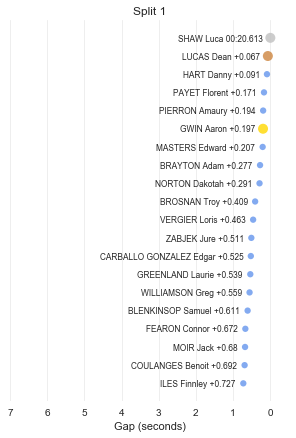

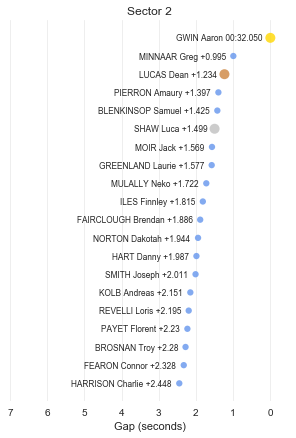

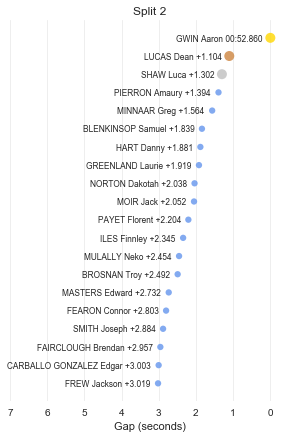

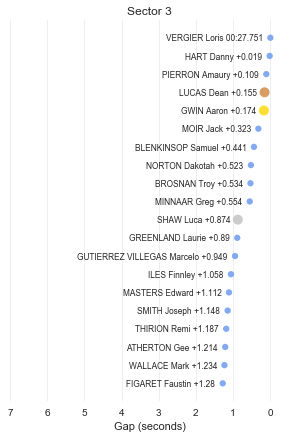

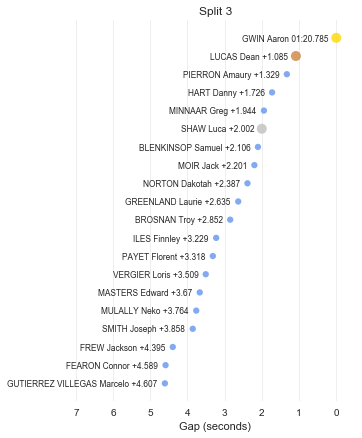

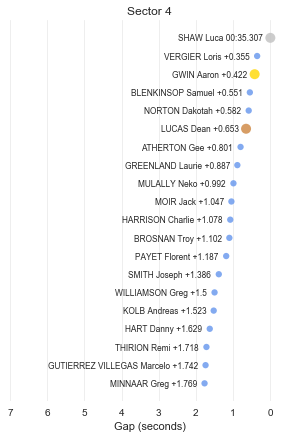

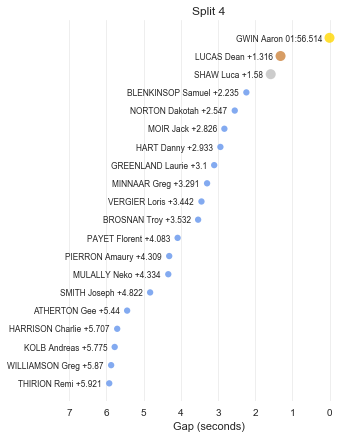

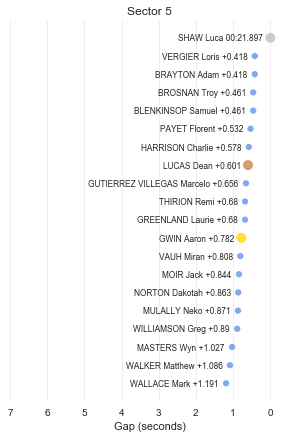

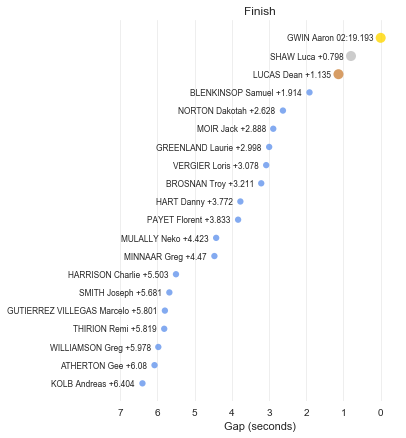

In [250]:
for i in range( 1, splits+1 ):
    x = str(i)
    split = 'split' + x
    if i > 1:
        drawScatter( split + '_sector_vs_best', 'Sector ' + x)
    drawScatter( split + '_vs_best', ( 'Split ' + x if i < splits else "Finish" ) )

### Position Consistency Heatmaps

Calculating chart size best fit

In [252]:
pltX = 1.4 * splits
pltY = 4 * ( topX / 10 )

Build list of riders for Y-axis, adding their finishing position next to them 

In [253]:
ylabels = [ j + ": " + str(i+1) for i, j in enumerate(df.name[:topX]) ]

Build data subset of ranking for each timing sector, then visualize consistency on a heatmap

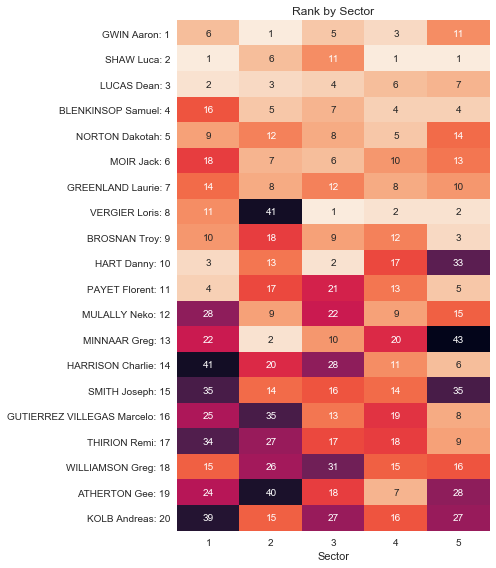

In [254]:
dfSectorRank = df[['split1_rank', 'split2_sector_rank', 'split3_sector_rank', 'split4_sector_rank', 'split5_sector_rank']][:topX].copy()

plt.figure(figsize=(pltX, pltY))
map = sns.heatmap(dfSectorRank, annot=True, yticklabels=ylabels, xticklabels=range(1,splits+1), cmap=sns.cm.rocket_r, cbar=False)
plt.xlabel( 'Sector' )
plt.title( 'Rank by Sector' )
plt.tight_layout()

Same as before but this time ranking for each race split, then visualize on a heatmap

On this heatmap, each rider represented will ideally gradually move darker to lighter left to right as their position improves toward the finish, unless they're winning from the start in which case it would stay the same (like Gwin from 2 onward)

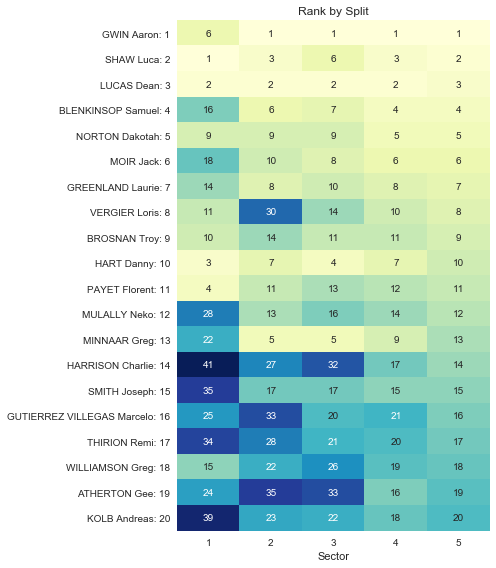

In [255]:
# Prepare data
dfSplitRank = df[['split1_rank', 'split2_rank', 'split3_rank', 'split4_rank', 'split5_rank']][:topX].copy()

# Configure and build heatmap
plt.figure(figsize=(pltX, pltY))
sns.heatmap( dfSplitRank, annot=True, yticklabels=ylabels, xticklabels=range(1,splits+1), cmap="YlGnBu", cbar=False )
plt.xlabel( 'Sector' )
plt.title( 'Rank by Split' )
plt.tight_layout()
# plt.savefig( 'heatmap_split.png', dpi=72 )

### Position Change Line Chart

This chart contains the same information as the second heatmap above but more clearly shows how riders changed positions as the race progressed until their final finishing place

We start by building up some lists of colors and lines styles to make the chart a little easier to read

In [257]:
color1 = Color( 'gold' )
color2 = Color( 'red' )
colorSat = 0.8
color1.saturation = colorSat
color2.saturation = colorSat
colors = list( color1.range_to( color2 , 5) )
# colors = list( 4* [ i.web for i in colors ] )
colors = list( np.repeat( [ i.web for i in colors ], 4 ) )
lines = 5*['-', '--', '-.', ':']
lines = 20*['-']

# from random import shuffle
# colors = list( color1.range_to( color2 , 20) )
# colors = ( list( [ i.web for i in colors ] ) )
# shuffle( colors )

# display( colors )


These lists are then used to build a color map and a bunch of other stuff calculated and configured before finally displayin the line chart

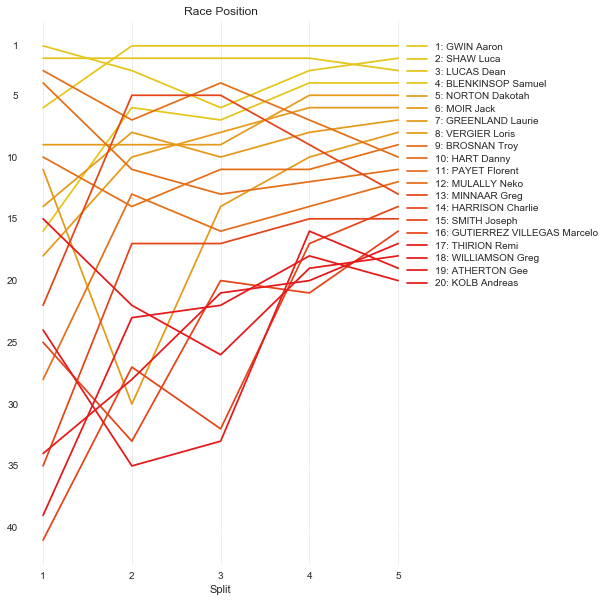

In [258]:
mpl.style.use('seaborn')

cyc = cycler('color', colors) + cycler('linestyle', lines)
mpl.rcParams['axes.prop_cycle'] = cycler(cyc)

pltX = 1.4 * splits
pltY = 5 * ( topX / 10 )

data = dfSplitRank.T

fig = plt.figure( figsize=(pltX, pltY) )
plt.plot( data, label=True )
ax = plt.gca()
ax.invert_yaxis()
ax.set_facecolor('xkcd:white')
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)
# plt.box(on=None)


plt.xlabel( 'Split' )
plt.title( 'Race Position' )

maxY = int(dfSplitRank['split1_rank'].max()+1)
plt.yticks( [1]+list(range( 5, maxY, 5 )), [1]+list(range( 5, maxY, 5 )) )

plt.xticks( range( 0, splits ), range( 1, splits+1 ) )
plt.grid( True, which='major', axis='y' )
plt.grid( True, which='major', axis='x', color='#EEEEEE' )

handles, labels = ax.get_legend_handles_labels()
# labelY = df['name'][:topX].values.tolist()
legendlabels = [ str(i+1) + ": " + j for i, j in enumerate(df.name[:topX]) ]
ax.legend( handles, legendlabels, loc=1, labelspacing=0.3445, bbox_to_anchor=(1.49, 0.977)) #, handletextpad=1

plt.show()

## Credits

### Author: Dominic Wrapson


> **@domwrap**
<br>
<img src="https://png.icons8.com/material/24/000000/github-2.png">
<img src="https://png.icons8.com/material/24/000000/stackoverflow.png">
<img src="https://png.icons8.com/material/24/000000/linkedin.png">
<img src="https://png.icons8.com/material/24/000000/windows8.png">
<img src="https://png.icons8.com/ios-glyphs/24/000000/instagram-new.png">
<img src="https://png.icons8.com/material/24/000000/twitter.png">
<a href="https://medium.com/@domwrap"><img src="https://png.icons8.com/material/24/000000/medium-logo.png"></a>
>
> <img src="https://png.icons8.com/material/24/000000/home.png"> http://dominic.wrapson.com
>
><img src="https://png.icons8.com/material/24/000000/cycling-mountain-bike.png"> [Hwulex](https://www.pinkbike.com/u/Hwulex/)

---

#### Special Thanks

Mark Shilton for the inspiration
- http://lookatthestats.blogspot.ca
- https://plus.google.com/+MarkShilton
- https://dirtmountainbike.com/author/mrgeekstats


<a href="https://icons8.com">Icon pack by Icons8</a>